# Классические модели. Работа с широкими данными

В общем случае данные для машинного обучения могут быть большими в двух смыслах

* Очень много наблюдений. Визуализируя данные для обучения как таблицу наблюдения-признаки, можно это представлять как очень "высокую" таблицу с огромных количеством записей. По этой причине такую ситуацию еще называют "высокими данными".

* Очень много признаков. Проводя такую же аналогию с таблицей, она бы выглядела как очень "широкая таблица" с гигантским количеством столбцов. Такую ситуацию аналогично называют "широкими данными".

Обе ситуации требуют различных подходов для решения. В этом семинаре будет говорить про "широкие данные".

### Подготовим данные и инструменты для дальшей работы

In [2]:
! mkdir -p sem06
%cd sem06

/home/ubuntu/sem06


Для демонстрационных целей будем использовать датасет с отзывами пользователей на различные медицинские препараты

Больше информации на UCI - https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

In [5]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
! unzip drugsCom_raw.zip

--2022-02-18 16:20:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip.1’

drugsCom_raw.zip.1  100%[===================>]  41.00M  10.9MB/s    in 4.1s    

2022-02-18 16:20:26 (9.89 MB/s) - ‘drugsCom_raw.zip.1’ saved [42989872/42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


Основной инструмент, который будем сегодня изучать - это Vowpal Wabbit.

Больше информации можно найти на официальном сайте - https://vowpalwabbit.org/

Ниже скачаем уже собранную версию VW , готовую к использованию

In [7]:
! whoami

ubuntu


In [8]:
! sudo wget http://finance.yendor.com/ML/VW/Binaries/vw-8.20190624 -O /usr/bin/vw
! sudo chmod +x /usr/bin/vw
! sudo chown ubuntu /usr/bin/vw

--2022-02-18 16:21:21--  http://finance.yendor.com/ML/VW/Binaries/vw-8.20190624
Resolving finance.yendor.com (finance.yendor.com)... 69.163.152.190
Connecting to finance.yendor.com (finance.yendor.com)|69.163.152.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9467376 (9.0M)
Saving to: ‘/usr/bin/vw’

/usr/bin/vw         100%[===================>]   9.03M  2.29MB/s    in 3.9s    

2022-02-18 16:21:26 (2.29 MB/s) - ‘/usr/bin/vw’ saved [9467376/9467376]



И заодно поставим всякие стандартные питоновские библиотеки для анализа данных

In [ ]:
! sudo apt-get update -y && sudo apt-get install graphviz -y

In [ ]:
! pip install numpy pandas sklearn dateparser pandarallel ipywidgets catboost graphviz

In [18]:
! /opt/conda/bin/jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [19]:
# Проверяем, что vw работает
! vw --help | head

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1
driver:
  --onethread           Disable parse thread
VW options:
  --ring_size arg (=256, ) size of example ring
  --strict_parse           throw on malformed examples
Update options:
  -l [ --learning_rate ] arg Set learning rate
  --power_t arg              t power value
  --decay_learning_rate arg  Set Decay factor for learning_rate between passes
  --initial_t arg            initial t value


## Хеширование признаков. Линейные модели.

Vowpal Wabbit - инструмент от компании Microsoft, который позволяет очень эффективно обучать линейные модели. Ключевая особенность данного инструмента - использования хешинг-трика. То есть все признаки изначально хешируются, что позволяет модели эффективно обрабатывать практически произвольное количество признаков.

### Формат данных
VW для обучения требует свой особенный формат хранения данных. Он выглядит следующим образом:

```
[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features
```

* Label - значение целевой переменной. Если не указывать, объект не будет использоваться в обучении
* Importance - вес объекта. Если не указывать, равен 1
* Tag - пометка объекта. Никак не влияет на процесс обучения, но добавляет семантики и "читаемости" данных для человека
* Namespace - название области признаков. Используется, чтобы разные по сути признаки с одинаковым названием не пересекались
* Features - признаки. Это или пара <название признака>:<значение признака> или просто <название признака>. В последнем случае будет считаться, что значение равно 1

Например, попробуем закодировать несколько элементов из Iris в этом формате

| Длина чашелистика | Ширина чашелистика | Длина лепестка | Ширина лепестка |  Вид ириса |
|:-----------------:|:------------------:|:--------------:|:---------------:|:----------:|
| 5.1               | 3.5                | 1.4            | 0.2             | setosa     |
| 4.9               | 3.0                | 1.4            | 0.2             | setosa     |
| 7.0               | 3.2                | 4.7            | 1.4             | versicolor |

Будем считать setosa классом 1, а versicolor классом -1.

In [20]:
%%writefile iris_1.example.vw
1 | sepal_length:5.1 sepal_width:3.5 petal_length:1.4 petal_width:0.2
1 | sepal_length:4.9 sepal_width:3.0 petal_length:1.4 petal_width:0.2
-1 | sepal_length:7.0 sepal_width:3.2 petal_length:4.7 petal_width:1.4

Writing iris_1.example.vw


В данном наборе мы дополнительно можем сгруппировать признаки - признаки для чашелистика и признаки для лепестка. Это позволит логически их разделить, сэкономит место, а также позволит в дальнейшем оперировать этими группами.

Запишем точно эти же данные, но с использованием именованных секций.

In [21]:
%%writefile iris_2.example.vw
1 |sepal length:5.1 width:3.5 |petal length:1.4 width:0.2
1 |sepal length:4.9 width:3.0 |petal length:1.4 width:0.2
-1 |sepal length:7.0 width:3.2 |petal length:4.7 width:1.4

Writing iris_2.example.vw


Подобный формат записи данных позволяет очень удобно записывать категориальные признаки в формате One-Hot Encoding. При таком кодировании мы бы для признака, соответствующего конкретной категории, выставили бы значение 1, а всем остальным - 0.

Например для признака с полом человека превратится в два признака

| gender_man | gender_woman |
|:----------:|:------------:|
| 1          | 0            |

Если же в VW не указывать явно значение признака, то оно будет в автоматическом режиме выставлено равным 1, чего мы и ожидаем при One-Hot кодировании.

Попробуем для примера записать вот такие данные в этом формате

| Класс |  Цвет фона | Включена ли темная тема | Размер шрифта | Межстрочный интервал |
|:-----:|:----------:|:-----------------------:|:-------------:|:--------------------:|
| 1     | White      | да                      | 12            | 1.5                  |
| -1    | Black      | нет                     | 14            | 1.5                  |
| 1     | White, Red | нет                     | 12            | 2                    |
| -1    | Black, Red | да                      | 15            | 1.5                  |

In [22]:
%%writefile design.example.vw
1 |color white |theme dark |font size:12.0 interval:1.5
-1 |color black |theme normal |font size:14.0 interval:1.5
1 |color white red |theme normal |font size: 12.0 interval:2.0
-1 |color black red |theme dark |font size: 15.0 interval:1.5

Writing design.example.vw


Можно заметить, что такой подход к кодированию также позволяет очень просто кодировать текстовые признаки в формате bag-of-words. При использовании bag-of-words мы для каждого слова добавляет отдельный бинарный признак, который равен 1, если слово есть в тексте.

Таким образом, чтобы закодировать в формате vw какой-то текст через bag-of-words достаточно... Просто написать этот текст! Единственное, что необходимо сделать дополнительно - это очистить сам текст от лишних символов, таких как знаки препинания, удаления, кавычки и так далее. Очищенный текст - это и есть кодирование признаков в vw.

Попробуем, например, закодировать вот такой набор данных.

| Оценка |                             Заголовок                              |                                                                      Комментарий                                                                     |
|:------:|:------------------------------------------------------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------:|
| 2      | To lazy to watch film                                              | My family and I normally do not watch local movies for the simple reason that they are poorly made                                                   |
| 5      | Well-directed and fairly notorious piece of Italian nunsploitation | This file is a genuinely moving and intelligent movie with plenty of nudity and gore.You can't go wrong with it.5 out of 5.                         |
| 3      | this was at one time the worst movie I had ever seen               | But since than time, I have seen many more movies that are worse (how is it possible??) Therefore, to be fair, I had to give this movie a 3 out of 5 |

In [23]:
%%writefile reviews.vw
2.0 |title to lazy to watch film |review my family and i normally do not watch local movies for the simple reason that they are poorly made
5.0 |title well directed and fairly notorious piece of italian nunsploitation |review this file is a genuinely moving and intelligent movie with plenty of nudity and gore you can t go wrong with it 8 out of 10 
3.0 |title this was at one time the worst movie i had ever seen |review but since than time  i have seen many more movies that are worse how is it possible  therefore to be fair  i had to give this movie a 3 out of 5 

Writing reviews.vw


In [24]:
! cat reviews.vw

2.0 |title to lazy to watch film |review my family and i normally do not watch local movies for the simple reason that they are poorly made
5.0 |title well directed and fairly notorious piece of italian nunsploitation |review this file is a genuinely moving and intelligent movie with plenty of nudity and gore you can t go wrong with it 8 out of 10 
3.0 |title this was at one time the worst movie i had ever seen |review but since than time  i have seen many more movies that are worse how is it possible  therefore to be fair  i had to give this movie a 3 out of 5 


В этом примере именованные секции играют важную роль, так как одно и тоже слово может оказаться и в заголовке и в тексте комментария. Без секций мы бы считали это одним признаком. Секции позволяют нам разделять слова, которые использовались в заголовке от слов, которые использовались в описании.

Итак, мы научились формировать данные для VW, самое время запустить его. Попробуем использовать наши примеры.

In [25]:
! vw reviews.vw --final_regressor reviews.model.bin

final_regressor = reviews.model.bin
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = reviews.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
4.000000 4.000000            1            1.0   2.0000   0.0000       25
13.653724 23.307447            2            2.0   5.0000   0.1722       36

finished run
number of examples = 3
weighted example sum = 3.000000
weighted label sum = 10.000000
average loss = 10.574909
best constant = 3.333333
total feature number = 106


In [26]:
! cat reviews.model.bin

   8.7.0     m      �@                      �dA�    ;9�=�"  ��=�.  ;9�=�6  �#k=Q=  �#k=QN  ��=>d   a0=�m  DC�=Fx  ��=��   a0=ݕ   a0=�  �#k=H�  ;9�=:�   a0=G�  �p�=��   a0=��  ��=�  ��=9�   a0=� �#k=�2 ��=4 ��=@ H
�  a0=� ��=� ��=� �p�=k� ;9�=\� 4
>p� �#k=L�  a0=Z�  a0=� �#k=��  a0==�  a0=�� �#k=�! �#k=*7 ��=�8 �ly=�:  a0=�; ��=�Q �#k=�U �#k=KY ��=�] �#k=_ �>ri ��=?�  a0=N� �#k=�� ��=К  a0=�  a0=�� ��=F� �#k=�  a0=B�  a0=�� ��=��  a0=� �#k=k  a0=� ��=� SQ�=y.  a0=MB  a0=+Q  a0=\T ��=�Y ��=�o ;9�=o ;9�=$� �#k=�  a0=v� �#k=�� �p�=]� �a�=�� �#k=�� ��=+�  a0=�� ��=��  a0=

На экране можно видеть отчет обучения, а в файл `reviews_result.vw.bin` записались веса модели. По-умолчанию используется линейная регрессия с MSE.

Для того, чтобы получить предсказания нет отдельной команды. Это связано с особым форматом работы инструмента. Можно считать, что vw всегда запускается в режиме обучения, однако есть несколько флагов, которые умеют контролировать этот процесс.

Схематично это можно изобразить на картинке

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vw-explanation.png" width="600">

Таким образом при каждом запуске VW получает входные данные, с которыми он сейчас будет работать. Далее он начинает обучение на этих данных. Если указан `--initial_regressor` то он возьмет указанные веса в качестве начальных - то есть попытается "дообучить" модель, которую мы указали. Параллельно с этим для каждого пройденного элемента он производит предсказание. Если указать параметр `--predictions`, то эти данные он отдельно запишет в файл. По окончанию обучения новые полученные веса он попробует сохранить в файл, указанный через `--final_regressor`. И также есть очень важный флаг `--testonly`, говорящий о том, что обновлять веса (то есть обучаться) в процессе не требуется.

Подобная схема позволяет более гибко задавать режимы работы. Вот возможные сценарии работы, которые можно выставить этими ключами.

* `--final_regressor` - просто обучаем модель на данных
* `--testonly`, `--initial_regressor`, `--predictions` - просто делаем предсказания модели на данных
* `--final_regressor`, `--initial_regressor` - дообучаем модель на новых данных

И так далее. Попробуем сделать предсказание на нашем же примере.

In [27]:
! vw --testonly \
    --initial_regressor reviews.model.bin \
    --predictions reviews_prediction.txt \
    reviews.vw

only testing
predictions = reviews_prediction.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = reviews.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.042279 0.042279            1            1.0   2.0000   1.7944       25
2.310258 4.578236            2            2.0   5.0000   2.8603       36

finished run
number of examples = 3
weighted example sum = 3.000000
weighted label sum = 10.000000
average loss = 1.583771
best constant = 3.333333
total feature number = 106


In [28]:
! cat reviews_prediction.txt

1.794381
2.860319
2.638340


### Решаем реальную задачу

Подключим все необходимые библиотеки и прочитаем данные

In [29]:
import pandas as pd
import numpy as np
import re
import dateparser
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
from pandarallel import pandarallel
pandarallel.initialize(use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [31]:
df_train = pd.read_csv("drugsComTrain_raw.tsv", delimiter='\t')
df_test = pd.read_csv("drugsComTrain_raw.tsv", delimiter='\t')
df = pd.concat([df_train, df_test])

In [32]:
df.dropna(inplace=True)

In [33]:
df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79


Задачу для обучения мы можем поставить себе произвольную. Чтобы было наглядно и в обучающей выборке было много разных признаков сформулируем задачу такую - **По написанному отзыву одного пользователя, определить какому количеству других пользователей эта информация окажется полезной**

Таким образом у нас изначально есть всего 4 признака следующей природы
* `drugName` - категория
* `condigion` - категория
* `review` - произвольный текст
* `rating` - вещественное число

А целевая переменная это `usefulCount` - тоже вещественное число

Подсчитаем количество признаков, которое нам потребуется для кодирования всех этих признаков, чтобы их можно было подать в линейную модель.

Категории будем колировать One-Hot, текст через Bag-of-Words, из временной метки сделаем категориальную переменную с днями недели, а вещественные будет подавать как есть.

In [34]:
len(df['drugName'].unique())  # Количество уникальных препаратов

3431

In [35]:
len(df['condition'].unique())  # Количество уникальных заболеваний

884

In [36]:
len(CountVectorizer().fit(df['review']).get_feature_names()) # Количество уникальных слов в корпусе

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


49855

Итого уже 3431 + 884 + 49855 + 1 = **54 178** признаков для кодирования.

In [37]:
def convert_to_vw(data):
    target = data['usefulCount']
    
    drug_name = data['drugName'].lower().replace(' ', '_')
    condition = data['condition'].lower().replace(' ', '_')
    
    raw_text = data['review'].lower()
    word_pattern = re.compile(r"[a-zA-Z0-9_]+")
    words = [match.group(0) for match in re.finditer(word_pattern, raw_text)]
    review = ' '.join(words)
    
    rating = data['rating']

    
    template = "{target} |d {drug_name} |c {condition} |r {review} |s rating:{rating}"
    return template.format(
        target=target,
        drug_name=drug_name,
        condition=condition,
        review=review,
        rating=rating
    )

In [38]:
_, example = next(df.iterrows())
example

Unnamed: 0                                                206461
drugName                                               Valsartan
condition                           Left Ventricular Dysfunction
review         "It has no side effect, I take it in combinati...
rating                                                       9.0
date                                                May 20, 2012
usefulCount                                                   27
Name: 0, dtype: object

In [39]:
convert_to_vw(example)

'27 |d valsartan |c left_ventricular_dysfunction |r it has no side effect i take it in combination of bystolic 5 mg and fish oil |s rating:9.0'

In [40]:
def write_vw(dataframe, filename):
    with open(filename, 'w') as f:
        for vw_record in dataframe.parallel_apply(convert_to_vw, axis=1):
            f.write(vw_record + '\n')

In [41]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=420)

In [42]:
%%time

write_vw(df_train, 'drugs.train.vw')
write_vw(df_test, 'drugs.test.vw')

CPU times: user 1.33 s, sys: 1.01 s, total: 2.34 s
Wall time: 20.5 s


In [43]:
! head -n 2 drugs.train.vw

17 |d anaprox-ds |c pain |r i recommend if for girls if they have menstrual pain it helps alot 10 15 mins after i take the pill i feel no more pain |s rating:10.0
1 |d levetiracetam |c epilepsy |r as a 42 year old female i have had seizures my entire life i have taken 14 anti convulsants at one point or another in an attempt to control my complex partial seizures but keppra is the worst medication i have ever taken the side effects are horrible although it 039 s the only medication that has been able to stop my seizures the side effects are so terrible that it 039 s not worth taking it i couldn 039 t string together a coherent thought had short term memory loss had awful mood swings and suddenly hated life everything was difficult i couldn 039 t think straight and felt emotionally raw all the time i could barely keep it together while on this medication every day of life was awful while on this medication i will never take it again |s rating:1.0


Итого мы разбили выборку на обучающую и тестовую и закодировали эти данные в нужном формате. Можно начинать обучать машины!

#### Запускаем чистый VW

Поставим обучаться VW без дополнительных параметров на нашем датасете

In [44]:
%%time

! vw --final_regressor drugs.model.bin drugs.train.vw

final_regressor = drugs.model.bin
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
289.000000 289.000000            1            1.0  17.0000   0.0000       30
145.348644 1.697287            2            2.0   1.0000   2.3028      145
240.409956 335.471268            4            4.0   7.0000   7.9989      157
1483.276169 2726.142381            8            8.0  24.0000   4.0544       73
827.101424 170.926679           16           16.0  11.0000  14.8396      137
2549.058402 4271.015380           32           32.0 135.0000   6.7423       55
2170.529700 1792.000997           64           64.0   9.0000  32.8455      150
1650.839727 1131.149754          128          128.0   4.0000  32.2044      149
1504.761907 1358.684087          256          256.0   3.0000  14

In [45]:
! vw --testonly --initial_regressor drugs.model.bin --predictions drugs.preductions.txt drugs.test.vw

only testing
predictions = drugs.preductions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
36.000000 36.000000            1            1.0   6.0000   0.0000       74
1793.657227 3551.314453            2            2.0  76.0000  16.4071       10
1092.279785 390.902344            4            4.0   4.0000   0.0000       68
884.345149 676.410512            8            8.0  23.0000  20.4742       44
507.483603 130.622057           16           16.0   7.0000  23.0774      126
508.988668 510.493733           32           32.0  13.0000  17.7603       47
596.315355 683.642042           64           64.0   3.0000  10.9192      108
1069.053975 1541.792594          128          128.0   9.0000  27.1967      115
999.484723 929.915471          256          256.0  29

In [46]:
! head drugs.preductions.txt

0
16.407093
49.673176
0
25.992844
31.923294
32.541691
20.474159
13.278885
41.239552


Для проверки качества регрессии будем считать обычный `R^2`. Для того, чтобы делать это просто, напишем функцию, которая будет считывать правильные ответы из vw файла, считывать предсказания и для них подсчитывать R2.

In [47]:
def calc_r2(predictions_filename, answers_filename):
    def read_target_from_vw(vw_record):
        return float(vw_record.split(' ')[0])
    
    with open(predictions_filename, 'r') as f:
        y_pred = np.array([float(value) for value in f.readlines()])
        
    with open(answers_filename, 'r') as f:
        y_expected = np.array([read_target_from_vw(value) for value in f.readlines()])
        
    return r2_score(y_expected, y_pred)

In [48]:
calc_r2('drugs.preductions.txt', 'drugs.test.vw')

0.18962522751793354

Качество пока не поражает воображение

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vince_mcmahon_1.png" width="300">

Основная причина - по умолчанию vw запускает всего одну эпоху с дефолтными параметрами. Этого явно недостаточно, чтобы выбить хорошее качество. Попробуем улучить качество, используя различные опции этого инструмента

#### Эпохи, размер хеша, лернинг рейт

Начнем тюнить нашу модель. Добавим больше эпох, увеличим размер хеша и подтянем лернинг рейт.

In [49]:
%%time

! vw --final_regressor drugs.model.bin drugs.train.vw \
    --learning_rate 15.0 \
    --bit_precision 22 \
    --passes 20 \
    --cache -k

final_regressor = drugs.model.bin
Num weight bits = 22
learning rate = 15
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.train.vw.cache
Reading datafile = drugs.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
289.000000 289.000000            1            1.0  17.0000   0.0000       30
256.536003 224.072006            2            2.0   1.0000  15.9690      145
328.243542 399.951080            4            4.0   7.0000  28.0000      157
1008.053105 1687.862669            8            8.0  24.0000  23.4970       73
3901.271561 6794.490017           16           16.0 224.0000   8.1367       38
2635.549805 1369.828049           32           32.0  25.0000  81.1440      147
2575.012004 2514.474203           64           64.0  13.0000  29.9650       77
1855.448868 1135.885732          128          128.0   6.0000   1.7608       80
1575.0869

In [50]:
! vw --testonly --initial_regressor drugs.model.bin --predictions drugs.preductions.txt drugs.test.vw

only testing
predictions = drugs.preductions.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
36.000000 36.000000            1            1.0   6.0000   0.0000       74
663.856689 1291.713379            2            2.0  76.0000  40.0596       10
419.834221 175.811752            4            4.0   4.0000   0.0000       68
627.090374 834.346527            8            8.0  23.0000  48.1149       44
507.308460 387.526547           16           16.0   7.0000  25.1145      126
409.221345 311.134229           32           32.0  13.0000  19.5480       47
501.073717 592.926089           64           64.0   3.0000   7.7352      108
567.331315 633.588913          128          128.0   9.0000  33.9953      115
472.671125 378.010935          256          256.0  29.000

In [51]:
calc_r2('drugs.preductions.txt', 'drugs.test.vw')

0.4738522304061916

Так уже гораздо интереснее!

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vince_mcmahon_2.png" width="300">

#### Регуляризация

Можно попробовать добавить регуляризацию, однако нужно быть очень аккуратным с ней - она расчитывается для **каждого** объекта и поэтому ее нужно выставлять очень маленькой, чтобы модель не скатилась в 0.

In [52]:
%%time
# Попробуем использовать 0.00001 для L1, но скорее всего это будет очень много

! vw --final_regressor drugs.model.bin drugs.train.vw \
    --learning_rate 15.0 \
    --bit_precision 22 \
    --passes 20 \
    --l2 0.00001 \
    --cache -k

using l2 regularization = 1e-05
final_regressor = drugs.model.bin
Num weight bits = 22
learning rate = 15
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.train.vw.cache
Reading datafile = drugs.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
289.000000 289.000000            1            1.0  17.0000   0.0000       30
256.536034 224.072067            2            2.0   1.0000  15.9690      145
328.245617 399.955200            4            4.0   7.0000  28.0000      157
1008.064921 1687.884224            8            8.0  24.0000  23.4958       73
3901.193176 6794.321432           16           16.0 224.0000   8.1362       38
2635.421075 1369.648973           32           32.0  25.0000  81.1145      147
2574.827465 2514.233856           64           64.0  13.0000  29.9484       77
1854.434202 1134.040939          128          128.0   6.

In [53]:
! vw --testonly --initial_regressor drugs.model.bin --predictions drugs.preductions.txt drugs.test.vw

only testing
predictions = drugs.preductions.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
5.711040 5.711040            1            1.0   6.0000   3.6102       74
2302.700979 4599.690918            2            2.0  76.0000   8.1790       10
1197.536105 92.371231            4            4.0   4.0000   3.3018       68
946.584093 695.632082            8            8.0  23.0000  14.1478       44
508.381847 70.179600           16           16.0   7.0000  21.2303      126
559.358821 610.335794           32           32.0  13.0000  13.8739       47
645.041917 730.725014           64           64.0   3.0000  10.0210      108
1205.428500 1765.815082          128          128.0   9.0000  22.5388      115
1161.321458 1117.214417          256          256.0  29.0

In [54]:
calc_r2('drugs.preductions.txt', 'drugs.test.vw')

0.0911722662960851

In [55]:
%%time

! vw --final_regressor drugs.model.bin drugs.train.vw \
    --learning_rate 15.0 \
    --bit_precision 22 \
    --passes 20 \
    --l2 1e-10 \
    --cache -k

using l2 regularization = 1e-10
final_regressor = drugs.model.bin
Num weight bits = 22
learning rate = 15
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.train.vw.cache
Reading datafile = drugs.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
289.000000 289.000000            1            1.0  17.0000   0.0000       30
256.536003 224.072006            2            2.0   1.0000  15.9690      145
328.243542 399.951080            4            4.0   7.0000  28.0000      157
1008.053105 1687.862669            8            8.0  24.0000  23.4970       73
3901.271561 6794.490017           16           16.0 224.0000   8.1367       38
2635.549805 1369.828049           32           32.0  25.0000  81.1440      147
2575.012001 2514.474197           64           64.0  13.0000  29.9650       77
1855.448896 1135.885790          128          128.0   6.

In [56]:
! vw --testonly --initial_regressor drugs.model.bin --predictions drugs.preductions.txt drugs.test.vw

only testing
predictions = drugs.preductions.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
36.000000 36.000000            1            1.0   6.0000   0.0000       74
664.806763 1293.613525            2            2.0  76.0000  40.0332       10
420.528389 176.250015            4            4.0   4.0000   0.0000       68
627.269756 834.011124            8            8.0  23.0000  48.0856       44
506.909774 386.549791           16           16.0   7.0000  25.1024      126
409.124411 311.339048           32           32.0  13.0000  19.5824       47
501.007402 592.890393           64           64.0   3.0000   7.7350      108
567.781104 634.554806          128          128.0   9.0000  33.9745      115
472.989698 378.198293          256          256.0  29.000

In [57]:
calc_r2('drugs.preductions.txt', 'drugs.test.vw')  # Все еще хуже

0.4736619084877385

Все еще хуже чем без регуляризации 

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vince_mcmahon_2.5.png" width="300">

Таким образом выставлять L* регуляризацию - это отдельное исскуство в VW. Можно попробовать выставлять сильно меньшее значение. Однако на моей практике очень редко получается руками подобрать хороший коэффициент - это возможно только если искать автоподбором. 

Так что совет - настраивайте L* регуляризации уже после настройки всех остальных параметров. Или вообще не используйте, VW имеет тенденцию неплохо обучаться и без нее.

#### Комбинируем признаки

Мы можем попробовать комбинировать (перемножать) признаки между собой, чтобы получать лучшее качество. Итоговое количество признаков сильно возрастет (если у нас есть признак с N значениями и с M значениями, то их перемножение даст еще N\*M признаков. Но нас это не смущает, так как у нас есть хешинг-трик! Можем себе позволить спокойно увеличивать количество признаков, не сильно переживая.

В нашем случае логично перемножить препараты и заболевания - признак препарат-заболевание звучит достаточно логично.

In [58]:
%%time

! vw --final_regressor drugs.model.bin drugs.train.vw \
    --learning_rate 15.0 \
    --bit_precision 22 \
    --passes 20 \
    --interactions dc \
    --cache -k

creating features for following interactions: dc 
final_regressor = drugs.model.bin
Num weight bits = 22
learning rate = 15
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.train.vw.cache
Reading datafile = drugs.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
289.000000 289.000000            1            1.0  17.0000   0.0000       31
248.808662 208.617325            2            2.0   1.0000  15.4436      146
325.960857 403.113052            4            4.0   7.0000  28.0000      158
1011.544804 1697.128750            8            8.0  24.0000  23.3711       74
3898.757096 6785.969389           16           16.0 224.0000   8.0795       39
2631.956169 1365.155242           32           32.0  25.0000  80.7135      148
2572.763285 2513.570400           64           64.0  13.0000  30.0844       78
1850.248228 1127.733172          128  

In [59]:
! vw --testonly --initial_regressor drugs.model.bin --predictions drugs.preductions.txt drugs.test.vw

creating features for following interactions: dc 
only testing
predictions = drugs.preductions.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
36.000000 36.000000            1            1.0   6.0000   0.0000       75
487.612732 939.225464            2            2.0  76.0000  45.3532       11
403.961487 320.310242            4            4.0   4.0000   0.0000       69
585.303350 766.645214            8            8.0  23.0000  45.8594       45
449.529677 313.756004           16           16.0   7.0000  18.1515      127
401.481933 353.434189           32           32.0  13.0000  19.4061       48
516.445572 631.409211           64           64.0   3.0000   8.4020      109
553.836858 591.228144          128          128.0   9.0000  33.3558      116
454.1798

In [60]:
calc_r2('drugs.preductions.txt', 'drugs.test.vw')

0.4911924441226795

Качество поднялось!

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vince_mcmahon_3.png" width="300">

Посчитаем количество признаков - 3431 + 884 + 49855 + 1 + 3431 \* 884 = **3 087 182**. Уже достаточно внушительное количество.

#### Используем N-граммы для текста

Можно попросить VW по определенному неймспейсу генерировать сразу N-граммы. Подход хорошо работает для текстов, так что мы можем попробовать использовать это для признака review.

Конечно этот еще сильнее взорвет количество признаков, но мы опять не сильно переживаем по этому поводу.

In [61]:
%%time

! vw --final_regressor drugs.model.bin drugs.train.vw \
    --learning_rate 15.0 \
    --bit_precision 22 \
    --passes 20 \
    --ngram r2 \
    --cache -k

Generating 2-grams for r namespaces.
final_regressor = drugs.model.bin
Num weight bits = 22
learning rate = 15
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.train.vw.cache
Reading datafile = drugs.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
289.000000 289.000000            1            1.0  17.0000   0.0000       55
173.416544 57.833088            2            2.0   1.0000   8.6048      285
234.932221 296.447899            4            4.0   7.0000  21.3651      309
1134.389025 2033.845829            8            8.0  24.0000  16.8272      141
3791.905764 6449.422503           16           16.0 224.0000   7.6771       71
2540.528538 1289.151311           32           32.0  25.0000  74.1889      289
2494.572742 2448.616947           64           64.0  13.0000  37.9520      149
1798.624631 1102.676520          128          128.0 

In [62]:
! vw --testonly --initial_regressor drugs.model.bin --predictions drugs.preductions.txt drugs.test.vw

Generating 2-grams for r namespaces.
only testing
predictions = drugs.preductions.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
36.000000 36.000000            1            1.0   6.0000   0.0000      143
92.785980 149.571960            2            2.0  76.0000  63.7700       15
46.472919 0.159858            4            4.0   4.0000   3.7340      131
726.686506 1406.900093            8            8.0  23.0000  24.3720       83
467.138790 207.591073           16           16.0   7.0000   7.5358      247
583.989696 700.840603           32           32.0  13.0000  13.3271       89
293.150106 2.310516           64           64.0   3.0000   2.9172      211
240.087881 187.025655          128          128.0   9.0000  11.1393      225
197.618541 155.149201     

In [63]:
calc_r2('drugs.preductions.txt', 'drugs.test.vw')

0.8619126818394689

Юху! Вот это уже реально похоже на какую-то модель, которую не стыдно и на продакшн катить!

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vince_mcmahon_4.png" width="300">

Количество признаков уже подобралось к отметке 3431 + 884 + 49855 + 1 + 49855 ^ 2 = **2 485 575 203**

#### Используем все вместе!

In [64]:
%%time

! vw --final_regressor drugs.model.bin drugs.train.vw \
    --learning_rate 20.0 \
    --bit_precision 23 \
    --passes 40 \
    --ngram r2 \
    --interactions dc \
    --cache -k

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
final_regressor = drugs.model.bin
Num weight bits = 23
learning rate = 20
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.train.vw.cache
Reading datafile = drugs.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
289.000000 289.000000            1            1.0  17.0000   0.0000       56
172.327087 55.654175            2            2.0   1.0000   8.4602      286
234.736885 297.146683            4            4.0   7.0000  21.2516      310
1134.530071 2034.323258            8            8.0  24.0000  17.2988      142
3821.997198 6509.464324           16           16.0 224.0000   7.8433       72
2605.829915 1389.662631           32           32.0  25.0000  82.3097      290
2535.426779 2465.023644           64           64.0  13.0000  39.4484      150
18

In [65]:
! vw --testonly --initial_regressor drugs.model.bin --predictions drugs.preductions.txt drugs.test.vw

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
only testing
predictions = drugs.preductions.txt
Num weight bits = 23
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
36.000000 36.000000            1            1.0   6.0000   0.0000      144
44.216021 52.432041            2            2.0  76.0000  68.7590       16
22.670023 1.124026            4            4.0   4.0000   3.6876      132
740.151412 1457.632801            8            8.0  23.0000  23.6109       84
453.024517 165.897623           16           16.0   7.0000   7.6341      248
663.569742 874.114967           32           32.0  13.0000  13.1812       90
332.543136 1.516530           64           64.0   3.0000   3.3430      212
275.126275 217.709414          128          128.0   9.

In [66]:
calc_r2('drugs.preductions.txt', 'drugs.test.vw')

0.8762065549926664

Лучший результат!

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vince_mcmahon_5.png" width="300">

Количество признаков перевалило за  3431 + 884 + 49855 + 1 + 7 + 49855 ^ 2 + 3431 \* 884=  **2 488 608 207**.

### Классификация

Помимо обычный линейрой регрессии с MSE , Vowpal Wabbit умеер решать и задачи классификации. Для этого нужно поменять обучаемую loss function. Список всех поддерживаемых loss можно найти здесь - https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Loss-functions .

Для начала переформатируем наш датасет для классификации - сделаем два класса - полезный и не полезный отзыв. Определять это будем по количеству usefullCount - если больше медианы, то полезный, если меньше - нет.

In [87]:
df['usefulCount'].median()

16.0

Важно отметить, что для бинарной классификации, классы должны быть 1 и -1.

In [88]:
def convert_to_vw_class(data):
    target = 1 if data['usefulCount'] > 16.0 else -1
    
    drug_name = data['drugName'].lower().replace(' ', '_')
    condition = data['condition'].lower().replace(' ', '_')
    
    raw_text = data['review'].lower()
    word_pattern = re.compile(r"[a-zA-Z0-9_]+")
    words = [match.group(0) for match in re.finditer(word_pattern, raw_text)]
    review = ' '.join(words)
    
    rating = data['rating']

    
    template = "{target} |d {drug_name} |c {condition} |r {review} |s rating:{rating}"
    return template.format(
        target=target,
        drug_name=drug_name,
        condition=condition,
        review=review,
        rating=rating
    )

In [89]:
_, example = next(df.iterrows())
example

Unnamed: 0                                                206461
drugName                                               Valsartan
condition                           Left Ventricular Dysfunction
review         "It has no side effect, I take it in combinati...
rating                                                       9.0
date                                                May 20, 2012
usefulCount                                                   27
Name: 0, dtype: object

In [90]:
convert_to_vw_class(example)

'1 |d valsartan |c left_ventricular_dysfunction |r it has no side effect i take it in combination of bystolic 5 mg and fish oil |s rating:9.0'

In [91]:
def write_vw_class(dataframe, filename):
    with open(filename, 'w') as f:
        for vw_record in dataframe.parallel_apply(convert_to_vw_class, axis=1):
            f.write(vw_record + '\n')

In [92]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=420)

In [93]:
%%time

write_vw_class(df_train, 'drugs.class.train.vw')
write_vw_class(df_test, 'drugs.class.test.vw')

CPU times: user 1.47 s, sys: 1.15 s, total: 2.62 s
Wall time: 21.6 s


In [96]:
! head -n 3 drugs.class.train.vw

1 |d anaprox-ds |c pain |r i recommend if for girls if they have menstrual pain it helps alot 10 15 mins after i take the pill i feel no more pain |s rating:10.0
-1 |d levetiracetam |c epilepsy |r as a 42 year old female i have had seizures my entire life i have taken 14 anti convulsants at one point or another in an attempt to control my complex partial seizures but keppra is the worst medication i have ever taken the side effects are horrible although it 039 s the only medication that has been able to stop my seizures the side effects are so terrible that it 039 s not worth taking it i couldn 039 t string together a coherent thought had short term memory loss had awful mood swings and suddenly hated life everything was difficult i couldn 039 t think straight and felt emotionally raw all the time i could barely keep it together while on this medication every day of life was awful while on this medication i will never take it again |s rating:1.0
1 |d contrave |c obesity |r i have been 

In [99]:
%%time

! vw --final_regressor drugs.model.bin drugs.class.train.vw \
    --loss_function logistic \
    --learning_rate 20.0 \
    --bit_precision 23 \
    --passes 40 \
    --ngram r2 \
    --interactions dc \
    --cache -k

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
final_regressor = drugs.model.bin
Num weight bits = 23
learning rate = 20
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.class.train.vw.cache
Reading datafile = drugs.class.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0   1.0000   0.0000       56
1.784606 2.876064            2            2.0  -1.0000   2.8181      286
1.551441 1.318277            4            4.0  -1.0000   1.9425      310
1.280395 1.009348            8            8.0   1.0000  -0.1680      142
1.133821 0.987248           16           16.0   1.0000  -0.6707       72
0.933702 0.733582           32           32.0   1.0000   3.8839      290
0.904595 0.875489           64           64.0  -1.0000   1.0534      150
0.844466 0.784337        

In [107]:
%%time

! vw drugs.class.test.vw \
    --testonly \
    --initial_regressor drugs.model.bin \
    --predictions predictions.txt

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
only testing
predictions = predictions.txt
Num weight bits = 23
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.class.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
45.949364 45.949364            1            1.0  -1.0000  -7.7786      144
28.838305 11.727246            2            2.0   1.0000   4.4245       16
36.769369 44.700434            4            4.0  -1.0000  -9.0952      132
28.369600 19.969830            8            8.0   1.0000   4.4692       84
25.758292 23.146984           16           16.0  -1.0000  -7.3193      248
26.630841 27.503391           32           32.0  -1.0000  -4.5997       90
41.285366 55.939890           64           64.0  -1.0000  -6.0912      212
38.983493 36.681621          128          128.0  -1.0000  -5

По умолчанию vw считает только регрессию - то есть значение логита для логистической регресии

In [108]:
! head predictions.txt

-7.778596
4.424507
5.885537
-9.095208
6.093756
1.256716
-7.066693
4.469213
-4.044488
6.824972


Чтобы предсказывать сразу классы для бинарной классификации можно указать флаг `--binary`

In [111]:
%%time

! vw drugs.class.test.vw \
    --binary \
    --testonly \
    --initial_regressor drugs.model.bin \
    --predictions predictions.txt

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
only testing
predictions = predictions.txt
Num weight bits = 23
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.class.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  -1.0000  -1.0000      144
0.000000 0.000000            2            2.0   1.0000   1.0000       16
0.000000 0.000000            4            4.0  -1.0000  -1.0000      132
0.125000 0.250000            8            8.0   1.0000   1.0000       84
0.125000 0.125000           16           16.0  -1.0000  -1.0000      248
0.093750 0.062500           32           32.0  -1.0000  -1.0000       90
0.046875 0.000000           64           64.0  -1.0000  -1.0000      212
0.039062 0.031250          128          128.0  -1.0000  -1.0000      226
0

In [112]:
! head predictions.txt

-1
1
1
-1
1
1
-1
1
-1
1


Чтобы предсказывать вероятности, то нужно указать vw что требуется пост-преобразование через `--link=logistic`

In [113]:
%%time

! vw drugs.class.test.vw \
    --link=logistic \
    --testonly \
    --initial_regressor drugs.model.bin \
    --predictions predictions.txt

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
only testing
predictions = predictions.txt
Num weight bits = 23
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.class.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
45.949364 45.949364            1            1.0  -1.0000   0.0004      144
28.838305 11.727246            2            2.0   1.0000   0.9882       16
36.769369 44.700434            4            4.0  -1.0000   0.0001      132
28.369600 19.969830            8            8.0   1.0000   0.9887       84
25.758292 23.146984           16           16.0  -1.0000   0.0007      248
26.630841 27.503391           32           32.0  -1.0000   0.0100       90
41.285366 55.939890           64           64.0  -1.0000   0.0023      212
38.983493 36.681621          128          128.0  -1.0000   0

In [114]:
! head predictions.txt

0.000418
0.988162
0.997228
0.000112
0.997748
0.778460
0.000852
0.988673
0.017217
0.998915


In [115]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def calc_class_metrics(predictions_filename, answers_filename):
    def read_target_from_vw(vw_record):
        return int((float(vw_record.split(' ')[0]) + 1) / 2)
    
    with open(predictions_filename, 'r') as f:
        y_pred = np.array([int(float(value) > 0.5) for value in f.readlines()])
        
    with open(answers_filename, 'r') as f:
        y_expected = np.array([read_target_from_vw(value) for value in f.readlines()])
        
    return accuracy_score(y_expected, y_pred), precision_score(y_expected, y_pred), recall_score(y_expected, y_pred)

In [117]:
calc_class_metrics('predictions.txt', 'drugs.class.test.vw')

(0.9601153366583541, 0.9561658387227794, 0.9636020151133501)

In [127]:
%%time

! vw --final_regressor drugs.model.bin drugs.class.train.vw \
    --loss_function logistic \
    --nn 3 \
    --inpass \
    --learning_rate 15.0 \
    --bit_precision 23 \
    --passes 50 \
    --ngram r2 \
    --interactions dc \
    --cache -k

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
final_regressor = drugs.model.bin
using input passthrough for neural network training
Num weight bits = 23
learning rate = 15
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = drugs.class.train.vw.cache
Reading datafile = drugs.class.train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0   1.0000   0.0000       56
1.941622 3.190097            2            2.0  -1.0000   3.1481      286
1.622740 1.303857            4            4.0  -1.0000   1.9788      310
1.305374 0.988007            8            8.0   1.0000  -0.0849      142
1.136837 0.968300           16           16.0   1.0000  -0.6021       72
0.934221 0.731605           32           32.0   1.0000   3.6791      290
0.903716 0.873211           64           64.0 

In [128]:
%%time

! vw drugs.class.test.vw \
    --link=logistic \
    --testonly \
    --initial_regressor drugs.model.bin \
    --predictions predictions.txt

Generating 2-grams for r namespaces.
creating features for following interactions: dc 
only testing
predictions = predictions.txt
using input passthrough for neural network testing
Num weight bits = 23
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = drugs.class.test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
50.758190 50.758190            1            1.0  -1.0000   0.0003      144
30.176360 9.594529            2            2.0   1.0000   0.9837       16
35.817200 41.458041            4            4.0  -1.0000   0.0002      132
26.169814 16.522428            8            8.0   1.0000   0.9843       84
23.266625 20.363437           16           16.0  -1.0000   0.0008      248
24.219722 25.172818           32           32.0  -1.0000   0.0252       90
36.875913 49.532104           64           64.0  -1.0000   0.0060      212
33.922824 

In [129]:
calc_class_metrics('predictions.txt', 'drugs.class.test.vw')

(0.9593827930174563, 0.953857649915935, 0.9646095717884131)

### Нативная работа с категориальными признаками. Деревья решений.

Как можно было видеть выше, огромное количество признаков может возникать из-за кодирования больших категориальных признаков или текста. Есть алтернативный способ работы с такими признаками - использование деревьев решений. Эти модели могут использовать изначальные признаки "как есть", а значит и нет вообще пробелмы с количеством признаков.

Один из хороших примерно инструментов, которые активно используют возможности деревьев для работы с категориями - CatBoost. Сама приставка Cat = Categorical, показывая что эта версия бустинга деревьев очень хорошо справляется с таким типом данных.

In [67]:
from catboost import Pool, CatBoostClassifier

In [68]:
df

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79


CatBoost сейчас в активной разработке, поэтому не все классные штуки еще реализовали. Например он не умеет нативно работать с текстовами признаками в задаче регрессии. Можно сделить за тем, как идет разработка в этом направлении на Github - https://github.com/catboost/catboost/issues/1221 .

Поэтому чтобы показать деревья во всей красе, будем решать задачу классификации.

In [69]:
df['usefulCount'].median()

16.0

In [77]:
X = df[['drugName', 'condition', 'review', 'rating']]
Y = df['usefulCount'].apply(lambda x: 1 if x > 16.0 else 0)

In [78]:
Y

0         1
1         1
2         1
3         0
4         1
         ..
161292    1
161293    1
161294    1
161295    1
161296    1
Name: usefulCount, Length: 320796, dtype: int64

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=420)

In [80]:
train_pool = Pool(
    X_train, 
    y_train, 
    cat_features=[0, 1], 
    text_features=[2], 
    feature_names=list(X_train.columns)
)
test_pool = Pool(
    X_test, 
    cat_features=[0, 1], 
    text_features=[2], 
    feature_names=list(X_test.columns)
)

In [81]:
model = CatBoostClassifier()

In [83]:
%%time

model.fit(train_pool, verbose=True, plot=False)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.110081
0:	learn: 0.6547231	total: 848ms	remaining: 14m 6s
1:	learn: 0.6254482	total: 1.74s	remaining: 14m 27s
2:	learn: 0.6027517	total: 2.6s	remaining: 14m 25s
3:	learn: 0.5868032	total: 3.42s	remaining: 14m 12s
4:	learn: 0.5727374	total: 4.26s	remaining: 14m 7s
5:	learn: 0.5616695	total: 5.12s	remaining: 14m 7s
6:	learn: 0.5475251	total: 6.16s	remaining: 14m 34s
7:	learn: 0.5361624	total: 7.06s	remaining: 14m 35s
8:	learn: 0.5278337	total: 7.94s	remaining: 14m 33s
9:	learn: 0.5204548	total: 8.82s	remaining: 14m 33s
10:	learn: 0.5150349	total: 9.67s	remaining: 14m 29s
11:	learn: 0.5102720	total: 10.5s	remaining: 14m 23s
12:	learn: 0.5077091	total: 11.1s	remaining: 14m 5s
13:	learn: 0.5044326	total: 12s	remaining: 14m 5s
14:	learn: 0.5029258	total: 12.8s	remaining: 13m 59s
15:	learn: 0.5003966	total: 13.6s	remaining: 13m 58s
16:	learn: 0.4986294	total: 14.4s	remaining: 13m 51s
17:	learn: 0.4969229	total: 15.2s	remaining: 13m 51s
18:	learn: 0.4955397	total: 16s	re

In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [85]:
y_pred = model.predict(test_pool)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

0.8199345386533666
0.8007978802584179
0.8469143576826197


Этот результат хорош сразу по многим параметрам

* Само значение качества достаточно высокое с первого запуска.
* Мы вообще практически ничего не делали с данными. Только дату немного отформатировали и сразу кинули в модель.
* Мы ничего не делали с моделью. Никаких дополнительных параметров настраивать не пришлось.
* Количество признаков у модели - всего 5! Нам не пришлось делать лишние признаки чтобы подать их в обучение.

<img src="https://raw.githubusercontent.com/ADKosm/lsml-2021-public/main/imgs/vince_mcmahon_6.png" width="300">

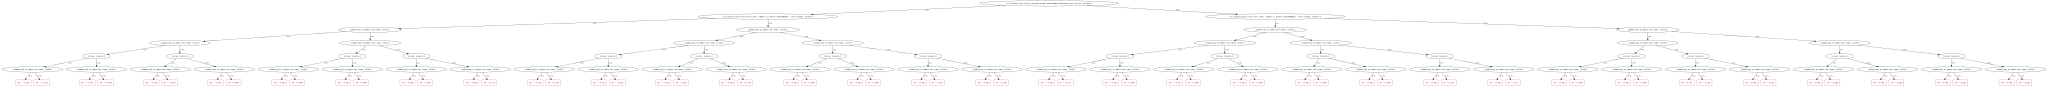

In [86]:
model.plot_tree(
    tree_idx=0,
    pool=train_pool
)